In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# The pre-trained roberta-based detector may only works w/
# - Huggingface version 2.9.1 (i.e., ```transformers==2.9.1```)
# - ```tokenizers==0.7.0```
# !pip install transformers==2.9.1

'''
~~~About Checkpoints~~~
base.pt is the most accurate checkpoint
base_1.pt is the latest checkpoint
'''
import numpy

FROM_CHECKPOINT = False
CHECKPOINTNAME = ""

import os
import csv
import time
import tqdm
# from tqdm.notebook import trange
from tqdm import trange
import math
import numpy as np
import torch
from torch import nn, optim
from transformers import RobertaForSequenceClassification, RobertaTokenizer

import utils as U

import sys

# setting path
sys.path.append('..')

from mutation_miniframework.Dataset import *
from mutation_miniframework.operators import deleteRandomArticle, replaceLetters, replaceFromDictionary, \
	replaceWordListWithRandomSelf

misspellings = U.loadJSONWordDictionary("../mutation_miniframework/mutation_data/misspellings.json")
antonyms = U.loadJSONWordDictionary("../mutation_miniframework/mutation_data/antonyms.json")
synonyms = U.loadJSONWordDictionary("../mutation_miniframework/mutation_data/misspellings.json")
randomList = []
with open("../mutation_miniframework/mutation_data/random_word.json") as randomJSON:
    randomBuffer = dict(json.load(randomJSON))
    randomList = randomBuffer["word"]

project_data_path = "./test"

text_data_path = os.path.join(project_data_path, 'data_10k', 'Parsed')
human_text_dir = os.path.join(text_data_path, 'train_val_test/human')
human_mutation_text_dir = os.path.join(text_data_path, 'train_val_test/mutation_human')
synthetic_text_dir = os.path.join(text_data_path, 'train_val_test/synthetic')
synthetic_mutation_text_dir = os.path.join(text_data_path, 'train_val_test/mutation_synthetic')
text_file_human_mutation = 'WikiHumanMutationFullSet.json'
text_file_human = 'WikiHumanFullSet.json'
text_file_synthetic = 'WikiSyntheticFullSet.json'
text_file_synthetic_mutation = 'WikiSyntheticMutationFullSet.json'

In [2]:
ckpt_dir = os.path.join(project_data_path, "ckpt")
output_path = os.path.join(ckpt_dir, "Ternary-Custom-Detector")
if(not os.path.exists(output_path)):
    print("Making Dir...\n\t%s" %output_path)
    os.makedirs(output_path)

roberta_detector_ckpt_dir = os.path.join(ckpt_dir, 'RoBERTa-Based-Detector')
roberta_detector_ckpt_name = 'detector-large.pt'
roberta_detector_ckpt_path = os.path.join(roberta_detector_ckpt_dir,
                                          roberta_detector_ckpt_name)
roberta_detector_ckpt_url = 'https://openaipublic.azureedge.net/gpt-2/detector-models/v1/detector-large.pt'

# Download RoBERTa-based Detector ckpt if needed
if (not os.path.exists(roberta_detector_ckpt_path)):
    if(not os.path.exists(roberta_detector_ckpt_dir)):
        print("Making Dir...\n\t%s" %roberta_detector_ckpt_dir)
        os.makedirs(roberta_detector_ckpt_dir)
    U.download_roberta_ckpt(roberta_detector_ckpt_url,
                            roberta_detector_ckpt_path)

# Load data
#[img name, captions, label]
train_data = U.load_data(human_text_dir, text_file_human,
                         human_mutation_text_dir, text_file_human_mutation,
                         synthetic_text_dir, text_file_synthetic,
                         synthetic_mutation_text_dir, text_file_synthetic_mutation,
                         train_test_split='train')
val_data = U.load_data(human_text_dir, text_file_human,
                       human_mutation_text_dir, text_file_human_mutation,
                       synthetic_text_dir, text_file_synthetic,
                       synthetic_mutation_text_dir, text_file_synthetic_mutation,
                       train_test_split='val')
test_data = U.load_data(human_text_dir, text_file_human,
                        human_mutation_text_dir, text_file_human_mutation,
                        synthetic_text_dir, text_file_synthetic,
                        synthetic_mutation_text_dir, text_file_synthetic_mutation,
                        train_test_split='test')

In [3]:
# set hyperparameters
batch_size = 1
epochs = 10
learning_rate = 0.0001
finetune_embeddings = False
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initiate pre-trained RoBERTa-based Detector
ckpt = None
if FROM_CHECKPOINT is True:
    ckpt = torch.load(os.path.join(output_path, CHECKPOINTNAME))
else:
    ckpt = torch.load(roberta_detector_ckpt_path) # checkpoint for pre-trained reberta detector, replace here with path.
model = RobertaForSequenceClassification.from_pretrained('roberta-large')
tokenizer = RobertaTokenizer.from_pretrained('roberta-large')

if FROM_CHECKPOINT is True:
    model.load_state_dict(ckpt)#Only do ckpt when loading
else:
    model.load_state_dict(ckpt['model_state_dict'])#Only do ckpt when loading
model = model.to(device)
model.classifier.out_proj = nn.Linear(1024, 4, bias=True)

# Freeze roberta weights (i.e., the embedding weights)
# leave the classifier tunable
for p in model.roberta.parameters():
    p.requires_grad = finetune_embeddings



BCE = nn.BCELoss()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Train Loop ##
t = trange(epochs, desc="", position=0, leave=True)

phases = ["train", "val"]
best_val_acc = 0
best_epoch = 0
train_hist = []
val_hist = []

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
from random import randrange
for e in t:
    model.to(device)
    for phase in phases:

        ## Initialization ##
        if phase == "train":
            model.train()
            data = np.array(train_data)
            np.random.shuffle(data)
        else:
            model.eval()
            data = np.array(val_data)

        epoch_loss = 0
        epoch_correct_pred = 0
        step_per_epoch = math.floor(len(data) / batch_size)

        ## Train/Val Loop ##
        for i in range(step_per_epoch):
            # Load one batch of data
            # batch size might have to be 1 due to varying caption length
            cur_data = data[i*batch_size:(i+1)*batch_size]
            cur_names = cur_data[:,0]
            cur_captions = cur_data[:,1]#TODO: Adjust for extra dimension, captions and labels
            cur_labels = cur_data[:,2].astype(np.int8)#Human Mutation is 0, real is 1, synthetic is 2, mutated synthetic is 3

            # Generate mutation
            # if need to generate mutation, add code here
            # print("DATA " + str(cur_data))
            dataDict = {}
            if phase == "train" and cur_labels == 0 or cur_labels == 3:
                dataDict[0] = [str(cur_data[:,1])]
                choice = randrange(0, 6)
                mutatedCaptionData = Dataset(dataDict, [""])
                if choice == 0:
                    deleteRandomArticle(mutatedCaptionData, [" a ", " an ", " the "], "", word_change_limit=99)
                if choice == 1:
                    replaceLetters(mutatedCaptionData, {
                        "a": "α",
                        "e": "ε"
                    }, "", word_change_limit=6)
                if choice == 2:
                    replaceFromDictionary(mutatedCaptionData, misspellings, "", word_change_limit=5)
                if choice == 3:#random word replacement
                    replaceWordListWithRandomSelf(mutatedCaptionData, randomList, "", word_change_limit=5)
                if choice == 4:#synonyms replacement
                    replaceFromDictionary(mutatedCaptionData, synonyms, "", word_change_limit=5)
                if choice == 5:#antonyms replacement
                    replaceFromDictionary(mutatedCaptionData, antonyms, "", word_change_limit=5)
                if choice == 6:
                    pass
                # print(f'{choice} MUTATION {mutatedCaptionData[0][0]}' )
                cur_data[:,1] = mutatedCaptionData[0][0]
                cur_captions = cur_data[:,1]
            # print(str(choice) + ":" + str(cur_data[:,1][0]))

            # Tokenize captions
            cur_token_ids = [tokenizer.encode(item) for item in cur_captions]
            cur_masks = [np.ones(len(item)) for item in cur_token_ids]

            # Convert to tensor and send data to device
            cur_token_ids = torch.tensor(np.array(cur_token_ids)).to(device)
            cur_labels = torch.tensor(np.array(cur_labels)).long().to(device)
            cur_masks = torch.tensor(np.array(cur_masks)).to(device)

            # For training
            if(phase == "train"):
                optimizer.zero_grad()
                logits = model(cur_token_ids, attention_mask=cur_masks)
                loss = loss_function(logits[0], cur_labels)
                loss.backward()
                optimizer.step()
            # scheduler may be needed in the future

            # For validation
            else:
                with torch.no_grad():
                    logits = model(cur_token_ids, attention_mask=cur_masks)
                    loss = loss_function(logits[0], cur_labels)

            # Track current performance
            # Count correct prediciton
            for kk in range(len(cur_labels)):
                prob = logits[0][kk].softmax(dim=-1)
                pred = torch.argmax(prob.detach().cpu())
                if(pred==cur_labels[kk]):
                    epoch_correct_pred +=  1.0
            # Add current loss to total epoch loss
            epoch_loss += loss.item()

            # Update progress bar
            if i % 100 == 0:
                t.set_description("Epoch/Step: %i/%i[Phase:%s]  Loss:%.4f  CorrectPred:%.4f [%i/%i]"
                              % (e, i, phase, loss.item(), epoch_correct_pred/(i+1), epoch_correct_pred, (i+1)))


        ## Compute epoch performance ##
        epoch_acc = epoch_correct_pred / (step_per_epoch * batch_size)
        epoch_loss = epoch_loss / step_per_epoch

        if(phase=="train"):
            train_hist.append([epoch_loss, epoch_acc])
            np.save(os.path.join(output_path,"train_hist.npy"),
                    np.asarray(train_hist))

        else:
            val_hist.append([epoch_loss, epoch_acc])
            np.save(os.path.join(output_path,"val_hist.npy"),
                    np.asarray(val_hist))

        if(phase == "val"):
            if(epoch_acc>best_val_acc):
                best_val_acc = epoch_acc
                best_epoch = e
                print("Epoch:%d Acc:%.4f higher than the previous best performance"
                      %(e, best_val_acc))
                print("Saving ckpt...")
                # save the CKPT
                torch.save(model.cpu().state_dict(),
                           os.path.join(output_path,"base.pt"))

    print("\nEpoch:%d   Train Loss/Acc: %.4f/%.4f   Val Loss/ACC %.4f/%.4f"
          %(e, train_hist[e][0], train_hist[e][1], val_hist[e][0], val_hist[e][1]))

torch.save(model.cpu().state_dict(),
           os.path.join(output_path,"base_"+str(e)+".pt"))

Epoch/Step: 0/47600[Phase:val]  Loss:0.5875  CorrectPred:0.7435 [35393/47601]:   0%|          | 0/10 [5:11:25<?, ?it/s]     

Epoch:0 Acc:0.7435 higher than the previous best performance
Saving ckpt...


Epoch/Step: 0/47600[Phase:val]  Loss:0.5875  CorrectPred:0.7435 [35393/47601]:  10%|█         | 1/10 [5:11:33<46:44:04, 18693.83s/it]


Epoch:0   Train Loss/Acc: 0.8852/0.6253   Val Loss/ACC 0.6303/0.7435


Epoch/Step: 1/47600[Phase:val]  Loss:2.7124  CorrectPred:0.6599 [31414/47601]:  20%|██        | 2/10 [10:36:41<42:05:04, 18938.12s/it]    


Epoch:1   Train Loss/Acc: 0.7701/0.6819   Val Loss/ACC 0.8323/0.6593


Epoch/Step: 2/47600[Phase:val]  Loss:0.8043  CorrectPred:0.7496 [35680/47601]:  20%|██        | 2/10 [16:19:55<42:05:04, 18938.12s/it]     

Epoch:2 Acc:0.7493 higher than the previous best performance
Saving ckpt...


Epoch/Step: 2/47600[Phase:val]  Loss:0.8043  CorrectPred:0.7496 [35680/47601]:  30%|███       | 3/10 [16:20:03<37:47:39, 19437.03s/it]


Epoch:2   Train Loss/Acc: 0.7377/0.6980   Val Loss/ACC 0.6210/0.7493


Epoch/Step: 3/47600[Phase:val]  Loss:2.0414  CorrectPred:0.7317 [34832/47601]:  40%|████      | 4/10 [21:44:46<32:25:05, 19450.89s/it]     


Epoch:3   Train Loss/Acc: 0.7184/0.7072   Val Loss/ACC 0.6472/0.7314


Epoch/Step: 4/47600[Phase:val]  Loss:0.6993  CorrectPred:0.7529 [35839/47601]:  40%|████      | 4/10 [27:10:09<32:25:05, 19450.89s/it]     

Epoch:4 Acc:0.7529 higher than the previous best performance
Saving ckpt...


Epoch/Step: 4/47600[Phase:val]  Loss:0.6993  CorrectPred:0.7529 [35839/47601]:  50%|█████     | 5/10 [27:10:17<27:02:55, 19475.09s/it]


Epoch:4   Train Loss/Acc: 0.7042/0.7128   Val Loss/ACC 0.5961/0.7529


Epoch/Step: 5/47600[Phase:val]  Loss:1.2751  CorrectPred:0.7540 [35893/47601]:  50%|█████     | 5/10 [32:44:04<27:02:55, 19475.09s/it]     

Epoch:5 Acc:0.7539 higher than the previous best performance
Saving ckpt...


Epoch/Step: 5/47600[Phase:val]  Loss:1.2751  CorrectPred:0.7540 [35893/47601]:  60%|██████    | 6/10 [32:44:12<21:49:32, 19643.07s/it]


Epoch:5   Train Loss/Acc: 0.6970/0.7170   Val Loss/ACC 0.6302/0.7539


Epoch/Step: 6/47600[Phase:val]  Loss:0.9024  CorrectPred:0.7408 [35265/47601]:  70%|███████   | 7/10 [38:33:00<16:41:25, 20028.42s/it]     


Epoch:6   Train Loss/Acc: 0.6893/0.7186   Val Loss/ACC 0.6433/0.7406


Epoch/Step: 7/47600[Phase:val]  Loss:1.1478  CorrectPred:0.7751 [36896/47601]:  70%|███████   | 7/10 [44:06:04<16:41:25, 20028.42s/it]     

Epoch:7 Acc:0.7749 higher than the previous best performance
Saving ckpt...


Epoch/Step: 7/47600[Phase:val]  Loss:1.1478  CorrectPred:0.7751 [36896/47601]:  80%|████████  | 8/10 [44:06:12<11:07:15, 20017.62s/it]


Epoch:7   Train Loss/Acc: 0.6795/0.7232   Val Loss/ACC 0.5607/0.7749


Epoch/Step: 8/47600[Phase:val]  Loss:1.2450  CorrectPred:0.7511 [35753/47601]:  90%|█████████ | 9/10 [49:34:34<5:32:02, 19922.88s/it]      


Epoch:8   Train Loss/Acc: 0.6744/0.7259   Val Loss/ACC 0.6666/0.7508


Epoch/Step: 9/47600[Phase:val]  Loss:1.3754  CorrectPred:0.7525 [35819/47601]: 100%|██████████| 10/10 [54:58:59<00:00, 19785.47s/it]      


Epoch:9   Train Loss/Acc: 0.6678/0.7286   Val Loss/ACC 0.6210/0.7520


Epoch/Step: 9/47600[Phase:val]  Loss:1.3754  CorrectPred:0.7525 [35819/47601]: 100%|██████████| 10/10 [54:58:59<00:00, 19793.98s/it]


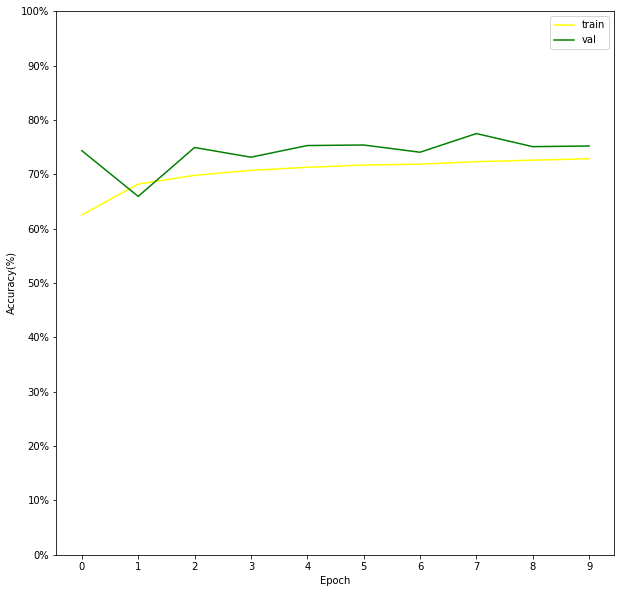

In [6]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

fig, ((ax1)) = plt.subplots(1, 1, figsize=(10, 10))
ax1.plot([train_hist[e][1]*100 for e in range(epochs)], color='yellow')
ax1.plot([val_hist[e][1]*100 for e in range(epochs)], color='green')
ax1.set_xticks([x for x in range(0, epochs, 1)])
ax1.set_yticks([y for y in range(0, 101, 10)])
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy(%)")
ax1.legend(['train', 'val'])

plt.show()